## Введение в анализ данных, ИАД-1

## НИУ ВШЭ, 2019-20 учебный год

### Домашнее задание №2

Задание выполнил(а): Бир Анастасия

### Общая информация

__Дата выдачи:__ 08.03.2019

__Дедлайн:__ 11:59 21.03.2019

### Оценивание и штрафы

Оценка за ДЗ вычисляется по следующей формуле:

$$
\text{points} \times 10 / \text{max points},
$$

где points — количество баллов, которое вы набрали, max_points - максимальное число баллов за задание. Бонусные задания отмечены звездочками (*)

За сдачу задания позже срока на итоговую оценку за задание накладывается штраф в размере 1 балл в день, но получить отрицательную оценку нельзя.

__Внимание!__ Домашнее задание выполняется самостоятельно. «Похожие» решения считаются плагиатом и все задействованные студенты (в том числе те, у кого списали) не могут получить за него больше 0 баллов.

### Формат сдачи

Загрузка файлов с решениями происходит в системе [Anytask](https://anytask.org/).


# kNN своими руками (4)

Реализуйте взвешенный алгоритм kNN для регрессии. Пусть нам нужно вычислить значение $y$ для некоторого $x$ при известных данных $\left(x_1, y_1\right), \ldots, \left(x_\ell, y_\ell\right)$. Предсказанием вашего регрессора будет являться

$$
\hat{y} = \frac{\sum\limits_{i=1}^kw_iy_{(i)}}{\sum\limits_{i=1}^kw_i},
$$
где $\left(x_{(1)}, y_{(1)}\right), \ldots, \left(x_{(k)}, y_{(k)}\right)$ - ближайшие $k$ объектов к $x$ по некоторой метрике $d(\cdot, \cdot)$, а $w_i = \frac{1}{d\left(x, x_{(i)}\right)}$. Ваш алгоритм должен уметь работать с двумя метриками:

$$
d\left(x_{(i)}, x\right) = \|x_{(i)} - x\|_2 = \sqrt{\sum\limits_{j=1}^n\left(x_{(i)}^j - x^j\right)^2}\qquad\text{(евклидова)}
$$
$$
d\left(x_{(i)}, x\right) = \|x_{(i)} - x\|_1 = \sum\limits_{j=1}^n\left|x_{(i)}^j - x^j\right|\qquad\text{(манхэттена)}
$$

Сверьте для нескольких комбинаций различных параметров свой результат на искусственной выборке с результатом соответствующего алгоритма из `sklearn` по метрике качества MSE.

In [1]:
import numpy as np
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import HuberRegressor
import matplotlib.pyplot as plt

In [73]:
class KNN:
    def __init__(self, metric='euclid', k=5):
        self.metric = metric
        self.k = k
        self.X_train = None
        self.y_train = None
        
    def fit(self, X_train, y_train):
        self.X_train = X_train
        self.y_train = y_train
        return self
        
    
    def predict(self, test):
        predictions = []
        for i in test:
            distances = []
            for index, j in enumerate(self.X_train):
                if self.metric == 'manhattan':
                    distance = 0
                    for x in range(len(i)):
                        distance += abs(i[x] - j[x])
                    distances.append([self.y_train[index], distance, index])
                if self.metric == 'euclid':
                    distance = 0
                    for x in range(len(i)):
                        distance += (i[x] - j[x]) ** 2
                    distances.append([self.y_train[index], np.sqrt(distance), index])
            distances.sort(key=lambda elem: elem[1]) 
            numer = 0
            denom = 0
            for n in range(self.k):
                numer += (1 / distances[n][1]) * distances[n][0]
                denom += (1 / distances[n][1])
            predictions.append(numer / denom)
        return predictions

In [4]:
np.random.seed(17032019)
X_train = np.random.randn(1000, 50)
y_train = np.random.randn(1000,)
X_test = np.random.randn(500, 50)
y_test = np.random.randn(500,)

In [75]:
%%time
my_knn = KNN()
my_knn.fit(X_train, y_train)
print(mean_squared_error(my_knn.predict(X_test), y_test))

1.143364989935662
CPU times: user 20.7 s, sys: 171 ms, total: 20.9 s
Wall time: 21 s


In [76]:
%%time
real_knn = KNeighborsRegressor(metric='euclidean', n_neighbors=5, weights='distance')
real_knn.fit(X_train, y_train)
print(mean_squared_error(real_knn.predict(X_test), y_test))

1.143364989935662
CPU times: user 56 ms, sys: 3.03 ms, total: 59 ms
Wall time: 58.5 ms


In [77]:
%%time
my_second_knn = KNN(metric='manhattan')
my_second_knn.fit(X_train, y_train)
print(mean_squared_error(my_second_knn.predict(X_test), y_test))

1.1768254941187883
CPU times: user 14.7 s, sys: 81.6 ms, total: 14.8 s
Wall time: 15 s


In [78]:
%%time
second_real_knn = KNeighborsRegressor(metric='manhattan', n_neighbors=5, weights='distance')
second_real_knn.fit(X_train, y_train)
print(mean_squared_error(second_real_knn.predict(X_test), y_test))

1.1768254941187883
CPU times: user 45.3 ms, sys: 2.65 ms, total: 48 ms
Wall time: 46.5 ms


# Линейная регрессия своими руками (4)

Реализуйте линейную регрессию с градиентным спуском для [функции потерь Хьюбера](https://en.wikipedia.org/wiki/Huber_loss):

$$
L_\delta\left(y, \hat{y}\right) =
\begin{cases}
\frac{1}{2}\left(y - \hat{y}\right)^2, \qquad &|y - \hat{y}| \leq \delta\\
\delta\left|y - \hat{y}\right| - \frac{1}{2}\delta^2,\qquad & \text{otherwise}
\end{cases}
$$

В таком случае общее значение функции потерь на всем датасете $(x_1, y_1), \ldots, (x_\ell, y_\ell)$ будет равно

$$
L = \frac{1}{\ell}\sum\limits_{i=1}^\ell L_\delta\left(y_i, \hat{y}_i\right)
$$

Проверьте работу вашего метода: выведите результаты его работы на той же искусственной выборке, что и в задаче выше (в качестве метрик качества используйте MSE и Huber loss). Постройте график зависимости значения функции потерь от итерации градиентного спуска.

*Вы можете опустить единичный признак в модели и не добавлять его в данные. Для данной искусственной выборки это не актуально, потому что целевая переменная в этом случае является случайной величиной из стандартного нормального распределения со средним 0.*

*Вектор весов в градиентном спуске можете инициализировать нулями.*

In [2]:
class LinearRegressionHuber:
    def __init__(self, delta=1.0, max_iter=1000, tol=1e-6, eta=1e-2):        
        self.delta = delta
        self.max_iter = max_iter
        self.tol = tol
        self.eta = eta
        self.w = None
        self.loss_history = None
        
        
    def fit(self, X_train, y_train): 
        self.loss_history = []
        self.w = np.zeros(X_train.shape[1])
        
        for i in range(self.max_iter):
            self.loss_history.append(self.calc_loss(X_train, y_train))  
            step = self.w - self.eta * self.calc_gradient(X_train, y_train)
            
            if np.linalg.norm(step - self.w) <= self.tol:      
                break
                
            self.w = step

        return self.loss_history
        
        
    def predict(self, X_test):          
        return np.dot(X_test, self.w)

   
    def calc_gradient(self, X, y):
        gradient = np.zeros(X_train.shape[1])
        z = np.dot(X, self.w)
        for xi, yi, zi in zip(X,y,z):
            if np.abs(yi - zi) <= self.delta:
                gradient += xi.T * (zi - yi)              
            else:
                gradient += self.delta * (xi.T * np.sign(zi - yi))
                    
        return gradient / X.shape[0]

    
    def calc_loss(self, X, y):
        y_pred = np.dot(X, self.w)        
        if np.linalg.norm(y - y_pred) <= self.delta:
            return 0.5 * np.linalg.norm(y - y_pred) ** 2
        else:
            return self.delta * np.linalg.norm(y - y_pred) - 0.5 * self.delta ** 2

In [5]:
%%time
my_huber_regr = LinearRegressionHuber()
my_huber_regr.fit(X_train, y_train)
print(mean_squared_error(y_test, my_huber_regr.predict(X_test)))

1.091952430747943
CPU times: user 12.6 s, sys: 74.8 ms, total: 12.7 s
Wall time: 6.5 s


In [6]:
%%time
real_huber_regr = HuberRegressor()
real_huber_regr.fit(X_train, y_train)
print(mean_squared_error(y_test, real_huber_regr.predict(X_test)))

1.095104163225779
CPU times: user 27.4 ms, sys: 3.93 ms, total: 31.4 ms
Wall time: 23.4 ms


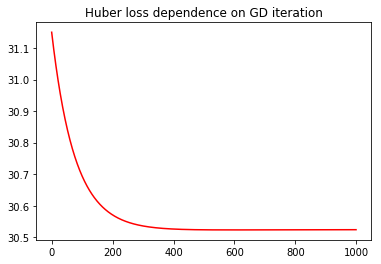

In [7]:
my_huber_regr = LinearRegressionHuber()
my_huber_regr.fit(X_train, y_train)

plt.plot(my_huber_regr.loss_history, color='red')
plt.title('Huber loss dependence on GD iteration')
plt.figsize = (15, 15)
plt.show()

# Практика

Пожалуйста, при использовании различных функций из библиотек импортируйте все, что вам понадобилось в данной части, в следующем блоке:

In [14]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

from sklearn.feature_selection import VarianceThreshold, SelectKBest, SelectFromModel, f_regression
from sklearn.linear_model import LinearRegression, Lasso, Ridge, LassoCV, RidgeCV
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, KFold
from sklearn.neighbors import KNeighborsRegressor
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler, StandardScaler, PolynomialFeatures, OneHotEncoder

%matplotlib inline

В этом домашнем задании вы поработаете с данными из другого соревнования на Kaggle: https://www.kaggle.com/c/house-prices-advanced-regression-techniques. Задача - предсказание цены дома.

In [15]:
data = pd.read_csv('train.csv', header=0)

In [16]:
data.shape

(1460, 81)

In [17]:
data.columns

Index(['Id', 'MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street',
       'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig',
       'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType',
       'HouseStyle', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd',
       'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType',
       'MasVnrArea', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual',
       'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1',
       'BsmtFinType2', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating',
       'HeatingQC', 'CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF',
       'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath',
       'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual',
       'TotRmsAbvGrd', 'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType',
       'GarageYrBlt', 'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual',
       'GarageCond', 'PavedDrive

In [18]:
data.drop('Id', axis=1, inplace=True)

## 1 (1)

Есть ли в данных пропуски? Если да, то для каждого столбца, в котором они имеются, посчитайте их количество и их долю от общего числа значений. Что вы наблюдаете?

In [19]:
data.columns[(data.isna().sum() != 0 ).to_list()]

Index(['LotFrontage', 'Alley', 'MasVnrType', 'MasVnrArea', 'BsmtQual',
       'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2',
       'Electrical', 'FireplaceQu', 'GarageType', 'GarageYrBlt',
       'GarageFinish', 'GarageQual', 'GarageCond', 'PoolQC', 'Fence',
       'MiscFeature'],
      dtype='object')

In [20]:
nan_columns = pd.DataFrame({'Number of gaps': data[data.columns[(data.isna().sum() != 0 ).to_list()]].isna().sum(),
                            'Proportion of gaps' : data[data.columns[(data.isna().sum() != 0 ).to_list()]].isna().sum() / len(data)})

In [21]:
nan_columns.sort_values('Proportion of gaps')

,Number of gaps,Proportion of gaps
Electrical,1,0.000685
MasVnrType,8,0.005479
MasVnrArea,8,0.005479
BsmtQual,37,0.025342
BsmtCond,37,0.025342
BsmtFinType1,37,0.025342
BsmtExposure,38,0.026027
BsmtFinType2,38,0.026027
GarageCond,81,0.055479
GarageQual,81,0.055479


## 2 (1)

Избавьтесь от пропусков. Для каждого из примененных методов обоснуйте свое решение. **Проверьте, что вы действительно избавились от пропусков.**

*Напоминание. В зависимости от типа столбца, можно заполнить пропуски, например, средним арифметическим, медианой, модой, можно какими-то отдельными значениями. А можно такие столбцы вообще удалить.*

In [22]:
for item in nan_columns[nan_columns['Proportion of gaps'] >= 0.8].index:
    data.drop(item, inplace=True, axis=1)

In [23]:
data['Electrical'].fillna(data['Electrical'].mode()[0], inplace=True)

In [24]:
data[['MasVnrType', 'MasVnrArea']][data['MasVnrType'] == 'None']['MasVnrArea'].value_counts()

0.0      859
1.0        2
312.0      1
344.0      1
288.0      1
Name: MasVnrArea, dtype: int64

In [25]:
data['MasVnrArea'] = data['MasVnrArea'].replace(to_replace=[1.0, 312.0, 344.0, 288.0],value=0)

In [26]:
data['MasVnrType'].fillna('None', inplace=True)
data['MasVnrArea'].fillna(0, inplace=True)

In [27]:
for item in ['BsmtQual', 'BsmtCond', 'BsmtFinType1', 'BsmtFinType2','BsmtExposure']:
    data[item].fillna('None', inplace=True)

In [28]:
data['LotFrontage'].fillna(data['LotFrontage'].median(), inplace=True)

In [29]:
data['FireplaceQu'].fillna('None', inplace=True)

In [30]:
for item in ['GarageType','GarageYrBlt','GarageFinish','GarageQual','GarageCond']:
    data[item].fillna('None', inplace=True)

In [31]:
(data.isnull().sum() > 0).any()

False

## 3 (1)

Обработайте категориальные признаки. В их обнаружении вам может помочь синтаксис `pandas` (например, можно обратить внимание на типы столбцов), а также описание датасета и его исследование. Объясните выбор метода (one-hot-encoding, label encoding, ...)

In [32]:
categorical_columns = data.columns[data.dtypes == 'object']

In [33]:
categorical_columns

Index(['MSZoning', 'Street', 'LotShape', 'LandContour', 'Utilities',
       'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2',
       'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st',
       'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond', 'Foundation',
       'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2',
       'Heating', 'HeatingQC', 'CentralAir', 'Electrical', 'KitchenQual',
       'Functional', 'FireplaceQu', 'GarageType', 'GarageYrBlt',
       'GarageFinish', 'GarageQual', 'GarageCond', 'PavedDrive', 'SaleType',
       'SaleCondition'],
      dtype='object')

In [34]:
onehot_encoder = OneHotEncoder(sparse=False, handle_unknown='ignore')

In [35]:
encoded_categorical_columns = pd.DataFrame(onehot_encoder.fit_transform(data[categorical_columns].astype(str)))

In [36]:
encoded_categorical_columns.columns = onehot_encoder.get_feature_names()

In [37]:
data = pd.concat([data, encoded_categorical_columns], axis=1).copy()

In [38]:
data.drop(categorical_columns, axis=1, inplace=True)

## 4 (0.5)

Вычислите и визуализируйте попарную корреляцию Пирсона между всеми признаками. Какие выводы можно сделать?

*Для визуализации можно использовать `seaborn.heatmap()`.*

In [39]:
data.corr(method='pearson')

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,...,x38_ConLw,x38_New,x38_Oth,x38_WD,x39_Abnorml,x39_AdjLand,x39_Alloca,x39_Family,x39_Normal,x39_Partial
MSSubClass,1.000000,-0.356718,-0.139781,0.032628,-0.059316,0.027850,0.040581,0.022505,-0.069836,-0.065649,...,0.014005,-0.045156,-0.014555,0.026359,0.005003,0.016241,0.030002,0.000983,0.024359,-0.051068
LotFrontage,-0.356718,1.000000,0.304522,0.234812,-0.053281,0.116685,0.083348,0.180348,0.214367,0.042463,...,-0.051283,0.128995,-0.023074,-0.091864,-0.021725,-0.036570,-0.018040,0.016250,-0.074146,0.127293
LotArea,-0.139781,0.304522,1.000000,0.105806,-0.005636,0.014228,0.013788,0.103383,0.214103,0.111170,...,-0.015040,0.020039,-0.005722,-0.002292,-0.029126,-0.013208,0.008966,-0.010781,0.005711,0.022635
OverallQual,0.032628,0.234812,0.105806,1.000000,-0.091932,0.572323,0.550684,0.405643,0.239666,-0.059119,...,-0.021172,0.327412,-0.057962,-0.225013,-0.103535,-0.041677,-0.044950,-0.025515,-0.143282,0.323295
OverallCond,-0.059316,-0.053281,-0.005636,-0.091932,1.000000,-0.375983,0.073741,-0.127920,-0.046231,0.040229,...,-0.019779,-0.156175,-0.050663,0.163684,-0.046367,-0.038888,-0.033444,-0.023873,0.161642,-0.151659
YearBuilt,0.027850,0.116685,0.014228,0.572323,-0.375983,1.000000,0.592855,0.311933,0.249503,-0.049107,...,-0.023431,0.346954,0.012122,-0.238463,-0.110233,-0.045601,-0.010104,-0.035785,-0.158427,0.343895
YearRemodAdd,0.040581,0.083348,0.013788,0.550684,0.073741,0.592855,1.000000,0.177979,0.128451,-0.067759,...,-0.039952,0.325647,-0.011431,-0.182733,-0.135942,-0.040294,-0.020727,-0.048056,-0.120577,0.322837
MasVnrArea,0.022505,0.180348,0.103383,0.405643,-0.127920,0.311933,0.177979,1.000000,0.261595,-0.068505,...,-0.022136,0.169394,-0.025499,-0.132695,-0.041116,-0.011266,-0.012828,-0.008319,-0.086731,0.165938
BsmtFinSF1,-0.069836,0.214367,0.214103,0.239666,-0.046231,0.249503,0.128451,0.261595,1.000000,-0.050117,...,-0.017825,0.044883,0.010652,-0.024778,-0.024832,-0.014874,0.021369,0.000765,-0.019560,0.044912
BsmtFinSF2,-0.065649,0.042463,0.111170,-0.059119,0.040229,-0.049107,-0.067759,-0.068505,-0.050117,1.000000,...,0.035715,-0.087162,-0.013098,0.036178,0.048347,-0.015130,-0.026277,-0.007929,0.041207,-0.085761


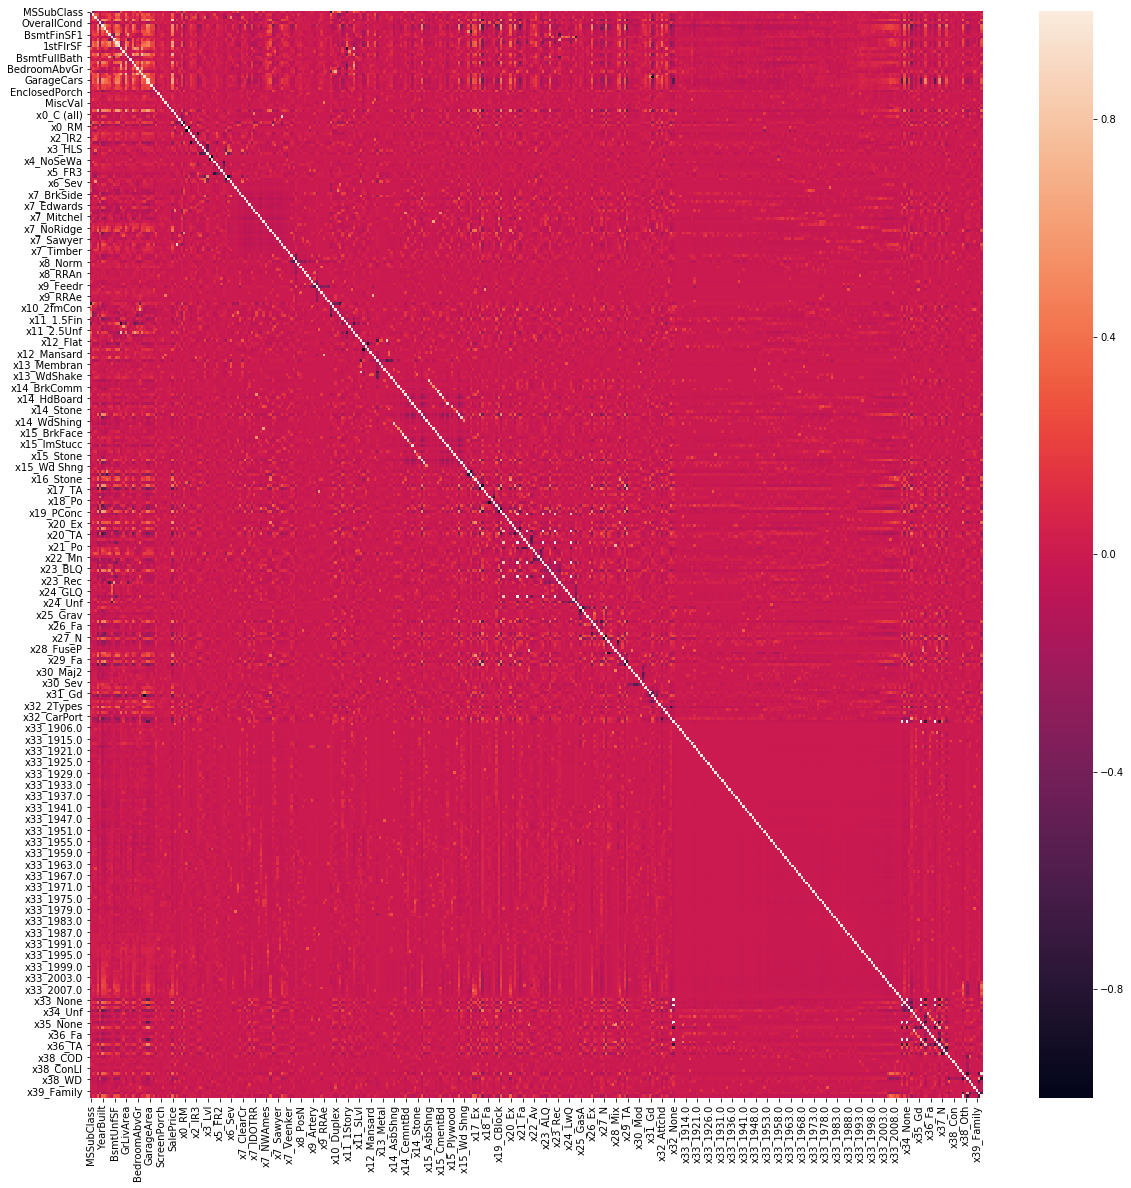

In [40]:
plt.subplots(figsize=(20, 20))
sns.heatmap(data.corr(method='pearson'))

## 5 (0.5)

Найдите признаки с максимальным и минимальным **абсолютным** значением коэффициента корреляции Пирсона с предсказываемым значением. Изобразите на графиках зависимость найденных признаков от предсказываемого значения.

*Не забудьте указать название графика и обозначить, что изображено по каждой из осей.*

In [41]:
correlation = abs(pd.DataFrame(data.drop('SalePrice', axis=1).apply(lambda x: x.corr(data['SalePrice'], 
                                                                                 method='pearson')), 
                           columns=['SalePriceCorr']).copy())

In [42]:
correlation[correlation['SalePriceCorr'] == correlation['SalePriceCorr'].min()]

,SalePriceCorr
x24_GLQ,0.000076


In [43]:
correlation[correlation['SalePriceCorr'] == correlation['SalePriceCorr'].max()]

,SalePriceCorr
OverallQual,0.790982


In [44]:
def print_graphs(data, x, y, title, color='red', figsize=(5, 5)):
    data.plot.scatter(x=x, y=y, c=color, figsize=figsize)
    plt.suptitle(title)
    plt.show()

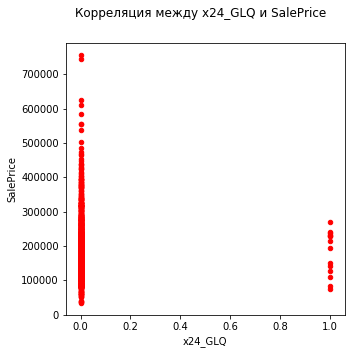

In [45]:
print_graphs(data, 'x24_GLQ', 'SalePrice', 'Корреляция между x24_GLQ и SalePrice')

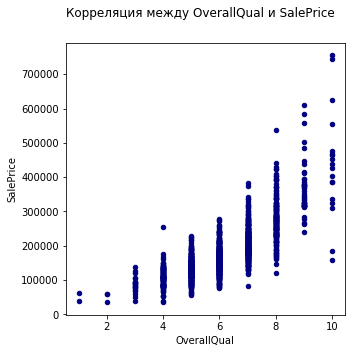

In [46]:
print_graphs(data, 'OverallQual', 'SalePrice', 'Корреляция между OverallQual и SalePrice', color='navy')

## 6 (0.5)

Постройте гистограмму распределения предсказываемого значения. Для избавления от разницы в масштабах, а также «смещения» распределения переменной в сторону нормального (что бывает полезно при статистическом анализе), можно прологарифмировать ее (это обратимое преобразование, поэтому целевую переменную легко восстановить). В данном случае воспользуйтесь `numpy.log1p`, чтобы сделать преобразование $y \to \ln\left(1 + y\right)$. Постройте гистограмму распределения от нового предсказываемого значения. Опишите наблюдения.

*В дальнейшем используйте в качестве предсказываемого значения вектор, который получился после логарифмирования.*

In [47]:
def distribution(data_column, xlabel, ylabel, title, loglp = False, figsize = (7, 7), color = 'red'):
    if loglp == False:
        data_column.hist(figsize=figsize, color=color)
    else:
        np.log1p(data_column).hist(figsize=figsize, color=color)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)
    plt.show()

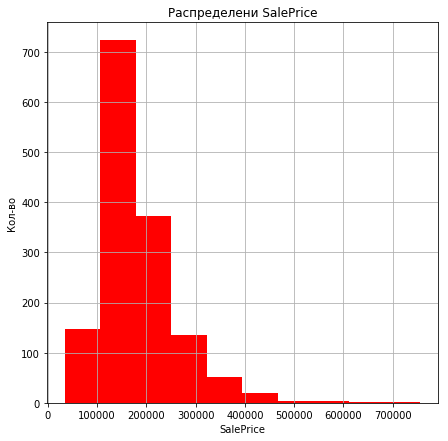

In [48]:
distribution(data['SalePrice'], 'SalePrice', 'Кол-во', 'Распределени SalePrice')

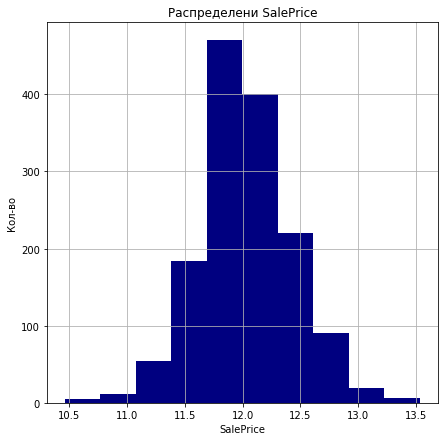

In [49]:
distribution(data['SalePrice'], 'SalePrice', 'Кол-во', 'Распределени SalePrice', loglp = True, color='navy')

In [50]:
data['SalePrice'] = np.log1p(data['SalePrice'])

Перейдем непосредственно к построению моделей. Разобьем выборку на обучение и контроль.

*Пожалуйста, **не меняйте** значение `random_state` в следующей ячейке.*

In [51]:
X_train, X_val, y_train, y_val = train_test_split(data.drop('SalePrice', axis=1), 
                                                  data['SalePrice'], random_state=17032019)

In [52]:
X_train.shape, X_val.shape, y_train.shape, y_val.shape

((1095, 382), (365, 382), (1095,), (365,))

## 7 (2)

Примените к данным следующие алгоритмы:

- kNN
- линейная регрессия
- Lasso
- Ridge

Для каждого из методов подберите гиперпараметры с помощью кросс-валидации. Обучите алгоритмы с лучшими гиперпараметрами на обучающей выборке и оцените качество по метрике **Root** Mean Squared Error. Какой из методов показывает себя лучше?

### kNN

In [53]:
knn = KNeighborsRegressor()
params = {'n_neighbors': np.arange(1, 
                                   201, 
                                   2), 
          'weights': ['uniform', 
                      'distance'], 
          'metric': ['euclidean', 
                     'manhattan']}
kf = KFold(n_splits=10, shuffle=True, random_state=42)
clf = GridSearchCV(knn, params, cv=kf, scoring='neg_mean_squared_error', n_jobs=-1)

In [54]:
%%time
clf.fit(X_train, y_train)

CPU times: user 15.6 s, sys: 962 ms, total: 16.6 s
Wall time: 9min 1s


GridSearchCV(cv=KFold(n_splits=10, random_state=42, shuffle=True),
       error_score='raise-deprecating',
       estimator=KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
          metric_params=None, n_jobs=None, n_neighbors=5, p=2,
          weights='uniform'),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'n_neighbors': array([  1,   3, ..., 197, 199]), 'weights': ['uniform', 'distance'], 'metric': ['euclidean', 'manhattan']},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='neg_mean_squared_error', verbose=0)

In [55]:
clf.best_params_, clf.best_score_

({'metric': 'manhattan', 'n_neighbors': 9, 'weights': 'distance'},
 -0.04148837613617743)

In [56]:
knn1 = KNeighborsRegressor(n_neighbors=9, weights='distance', metric='manhattan')
knn1.fit(X_train, y_train)
np.sqrt(mean_squared_error(y_val, knn1.predict(X_val)))

0.19922140348473633

### Линейная регрессия

In [57]:
lin_reg = LinearRegression()
params_regr = {'fit_intercept':[True,False], 
               'normalize':[True,False], 
               'copy_X':[True, False]}
clf_regr = GridSearchCV(lin_reg, params_regr, iid=True, cv=kf, scoring='neg_mean_squared_error')

In [58]:
%%time
clf_regr.fit(X_train, y_train)

CPU times: user 4.78 s, sys: 112 ms, total: 4.89 s
Wall time: 2.57 s


GridSearchCV(cv=KFold(n_splits=10, random_state=42, shuffle=True),
       error_score='raise-deprecating',
       estimator=LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False),
       fit_params=None, iid=True, n_jobs=None,
       param_grid={'fit_intercept': [True, False], 'normalize': [True, False], 'copy_X': [True, False]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='neg_mean_squared_error', verbose=0)

In [59]:
clf_regr.best_params_, clf_regr.best_score_

({'copy_X': True, 'fit_intercept': False, 'normalize': True},
 -0.028445271971622187)

In [60]:
lin_reg_2 = LinearRegression(copy_X= True, fit_intercept= False, normalize= True)

In [61]:
%%time
lin_reg_2.fit(X_train, y_train)

CPU times: user 48 ms, sys: 2.14 ms, total: 50.1 ms
Wall time: 27.4 ms


LinearRegression(copy_X=True, fit_intercept=False, n_jobs=None,
         normalize=True)

In [62]:
np.sqrt(mean_squared_error(y_val, lin_reg_2.predict(X_val)))

0.1378571962854244

### Lasso

In [63]:
lassocv = LassoCV(alphas=None, cv=15, max_iter=100000, normalize=True)
lassocv.fit(X_train, y_train)

LassoCV(alphas=None, copy_X=True, cv=15, eps=0.001, fit_intercept=True,
    max_iter=100000, n_alphas=100, n_jobs=None, normalize=True,
    positive=False, precompute='auto', random_state=None,
    selection='cyclic', tol=0.0001, verbose=False)

In [64]:
lasso_regression = Lasso(alpha=lassocv.alpha_, normalize=lassocv.normalize)
lasso_regression.fit(X_train, y_train)
np.sqrt(mean_squared_error(y_val, lasso_regression.predict(X_val)))

0.1194691953295552

### Ridge

In [65]:
alphas = np.logspace(-10, 1, 400)
ridgecv = RidgeCV(alphas=alphas, normalize=True)
ridgecv.fit(X_train, y_train)

RidgeCV(alphas=array([1.00000e-10, 1.06554e-10, ..., 9.38493e+00, 1.00000e+01]),
    cv=None, fit_intercept=True, gcv_mode=None, normalize=True,
    scoring=None, store_cv_values=False)

In [66]:
ridge = Ridge(alpha=ridgecv.alpha_, normalize=ridgecv.normalize)
ridge.fit(X_train, y_train)
np.sqrt(mean_squared_error(y_val, ridge.predict(X_val)))

0.13177421386032998

## 8 (1)

Постройте гистограммы значений весов для линейной регрессии, Lasso и Ridge. Опишите наблюдения. В чем различия между полученными наборами весов и почему?

In [67]:
def print_weight_graphs(coeffs, title, xlabel='weight', ylabel= 'quantity', color='blue', figsize=(5, 5)):
    plt.rcParams['figure.figsize'] = figsize
    plt.hist(coeffs, color=color)
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.show()

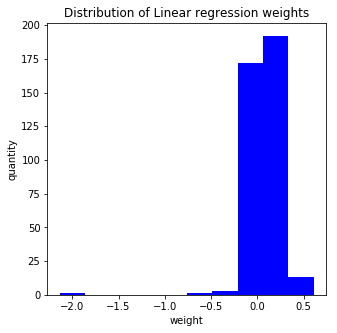

In [68]:
print_weight_graphs(lin_reg_2.coef_, 'Distribution of Linear regression weights')

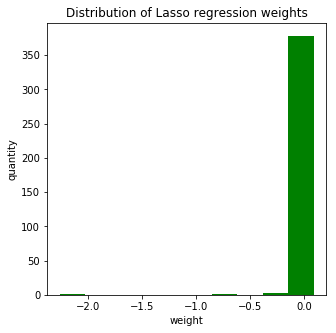

In [69]:
print_weight_graphs(lasso_regression.coef_, 'Distribution of Lasso regression weights', color='green')

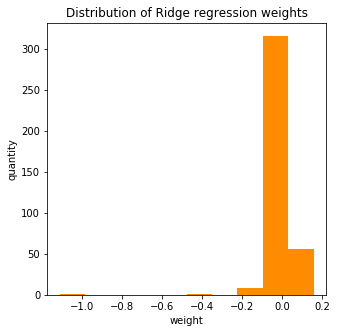

In [70]:
print_weight_graphs(ridge.coef_, 'Distribution of Ridge regression weights', color='darkorange')

## 9 (0.5)

Добейтесь того, чтобы в заданиях выше ваш лучший алгоритм давал качество не больше 0.125 на тестовых данных по метрике RMSE (если вы дошли до этого задания, а качество выше уже удовлетворяет этому условию, вы автоматически получите за него полный балл).

In [71]:
np.sqrt(mean_squared_error(y_val, lasso_regression.predict(X_val))) < 0.125

True

## 10* (0.5)

Добейтесь того, чтобы в заданиях выше ваш лучший алгоритм давал качество не больше 0.121 на тестовых данных по метрике RMSE. Для этого вы можете использовать самые разные методы, какие захотите - отбор признаков, генерация новых, разные способы предобработки данных. Единственное ограничение - не использовать никакие алгоритмы регрессии, кроме kNN, линейной регрессии, Lasso и Ridge.

In [72]:
np.sqrt(mean_squared_error(y_val, lasso_regression.predict(X_val))) < 0.121

True

# Теория

За данную часть можно получить бонусные баллы. Решения необходимо оформить в этом же файле в ячейках типа Markdown, пользуясь $\LaTeX$ для записи математических формул.

## 1* (0.5)

Найдите константу $C$, решающую следующую задачу ($0 < \tau < 1$ фиксировано):

$$
\sum\limits_{i=1}^\ell\rho_\tau\left(y_i - C\right) \to \min_C,
$$

где

$$
\rho_\tau(z) =
\begin{cases}
\tau z, & z > 0\\
(\tau - 1)z, & z \leq 0
\end{cases}
$$

### Мое решение:

$$
\sum\limits_{i=1}^\ell\rho_\tau\left(y_i - C\right) \to \min_C,
$$

$$
Пусть\;n\;-\;число\;y,\;m\;-\;число\;(y_i\,-\,C)> 0
$$

$$
Тогда\;сумма\;такая:
$$
$$
\tau \cdot \sum\limits_{i=1}^\ell\left(y_i - C\right)[y_i>C] + (\tau-1) \cdot \sum\limits_{i=1}^\ell\left(y_i - C\right)[y_i\leq C]=
$$
$$
\tau \cdot \sum\limits_{i=1}^\ell y_i [y_i>C] - \tau \cdot C \cdot m + (\tau-1) \cdot \sum\limits_{i=1}^\ell y_i [y_i\leq C]-(\tau-1)\cdot C \cdot (n-m) = 
$$
$$
\tau \cdot \sum\limits_{i=1}^\ell y_i [y_i>C]-\tau \cdot C \cdot m + \tau \cdot \sum\limits_{i=1}^\ell y_i [y_i\leq C] - \sum\limits_{i=1}^\ell y_i [y_i\leq C] + \tau \cdot C \cdot (m-n) + C\cdot(n-m)=
$$
$$
\tau \cdot \sum\limits_{i=1}^\ell y_i - \tau \cdot C \cdot n + C\cdot n - m \cdot C - \sum\limits_{i=1}^\ell y_i [y_i\leq C] = 
$$
$$C\cdot(-\tau\cdot n + n - m) - \sum\limits_{i=1}^\ell y_i [y_i\leq C] \to \min_C
$$
$$
Берем\;производную\;по\;С:
$$
$$
-\tau \cdot n + n - m = 0
$$
$$
m = n\cdot(1-\tau)
$$
$$
\frac{m}{n} = (1-\tau)
$$
$$
\sum\limits_{i=1}^\ell[y_i> C] \; ко\;всем\;y=1-\tau,\;значит,\;по\;определению\;квантиля,\; C\;-\;\tau\;квантиль\,y
$$